<a href="https://colab.research.google.com/github/alifele/Brain_Computer_Interface-Competition-/blob/master/HAR_based_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('/content/drive/My Drive/EEG_BCI/')
import datafetch
import plotters
import random


In [0]:
from sklearn.model_selection import train_test_split

In [0]:
def History_plotter(his):
  global History
  his_list = ['loss', 'accuracy', 'val_loss', 'val_accuracy']
  for i, name in enumerate(his_list):
    History[i]+=(his.history[name])
  plt.figure(figsize=(8, 5))
  plt.plot(np.array(History).T, '-')
  plt.legend(his_list)


In [0]:
under_sample =1
t = np.linspace(0,3,int(7200/under_sample))
f = np.linspace(1/3, 2400, int(7200/under_sample))

In [0]:
Data = []
class_list = ['none'] + [ 'train_data_class{}'.format(i+1) for i in range(4)]
Label = []


for i in range(15):
  subj = datafetch.fetch_subject(i+1)
  for class_ in range(1,5):
    for trial in range(25):
      Data.append(subj[class_list[class_]][trial][::under_sample, :])
      Label += [class_]

Data = np.array(Data)
Label = np.array(Label)

rnd = [i for i in range(1500)]
np.random.shuffle(rnd)

Data = Data[rnd]
Label = Label[rnd]

In [0]:
x_train, x_test, y_train, y_test = train_test_split(Data, Label, test_size = 0.1)
History = [[] for i in range(4)]
#del Data, Label

In [0]:
def unc():
  for i in range(500):
    rnd = np.random.randint(1350, size=(2))
    while y_train[rnd][0] != y_train[rnd][1]:

      if y_train[rnd][0] == y_train[rnd][1]:
        break
      rnd = np.random.randint(x_train.shape[0], size=(2))
    if (i%30 ==0):
      print('done{}'.format(i))

    new_data =  np.mean(x_train[rnd], axis=0)
    new_data = np.expand_dims(new_data, axis=0)
    x_train  = np.append(x_train, new_data, axis=0)
    y_train = np.append(y_train, y_train[rnd[0]])
  %cd /content/drive/My Drive/EEG_BCI
  %pwd
  np.save('x_train', x_train)
  np.save('x_test', x_test)
  np.save('y_train', y_train)
  np.save('y_test', y_test)

In [0]:
from pandas import DataFrame

In [0]:
import tensorflow as tf
from tensorflow import keras


In [0]:
global History
History = [[] for i in range(4)]

In [0]:
model = keras.models.Sequential()

active = 'relu'

model.add(keras.layers.AvgPool1D(5, input_shape=(int(7200/under_sample),63) ))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=20, kernel_size=11, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.AvgPool1D(pool_size=3))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=10, kernel_size=5, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.AvgPool1D(pool_size=4))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(10, activation=active))
model.add(keras.layers.Dense(10, activation=active))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=7, kernel_size=2, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.AvgPool1D(pool_size=3))


model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Flatten())

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(60, activation=active, kernel_initializer="he_normal"))

model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(50, activation = active, kernel_initializer="he_normal"))

model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(20, activation=active,  kernel_initializer="he_normal" ))

model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(4, activation='softmax', kernel_initializer="he_normal"))

#Lower Fluctiotion in val_loss


In [67]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling1d_29 (Averag (None, 1440, 63)          0         
_________________________________________________________________
batch_normalization_60 (Batc (None, 1440, 63)          252       
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 1430, 20)          13880     
_________________________________________________________________
average_pooling1d_30 (Averag (None, 476, 20)           0         
_________________________________________________________________
batch_normalization_61 (Batc (None, 476, 20)           80        
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 472, 10)           1010      
_________________________________________________________________
average_pooling1d_31 (Averag (None, 118, 10)         

In [0]:
opt = keras.optimizers.Adam( lr=0.001)
model.compile(optimizer='adam', 
              metrics= ['accuracy'],
              loss= 'sparse_categorical_crossentropy')

In [70]:
his = model.fit(x_train, y_train-1, epochs=50, batch_size=5, validation_data=(x_test, y_test-1))

Epoch 1/50
430/430 [==============================] - 4s 9ms/step - loss: 1.6590 - accuracy: 0.2567 - val_loss: 1.4340 - val_accuracy: 0.2533
Epoch 2/50
430/430 [==============================] - 4s 9ms/step - loss: 1.5260 - accuracy: 0.2456 - val_loss: 1.3983 - val_accuracy: 0.2667
Epoch 3/50
430/430 [==============================] - 4s 9ms/step - loss: 1.4492 - accuracy: 0.2619 - val_loss: 1.3944 - val_accuracy: 0.2333
Epoch 4/50
430/430 [==============================] - 4s 8ms/step - loss: 1.4337 - accuracy: 0.2372 - val_loss: 1.3920 - val_accuracy: 0.2200
Epoch 5/50
430/430 [==============================] - 4s 8ms/step - loss: 1.4046 - accuracy: 0.2553 - val_loss: 1.3843 - val_accuracy: 0.2733
Epoch 6/50
430/430 [==============================] - 4s 9ms/step - loss: 1.4000 - accuracy: 0.2381 - val_loss: 1.3845 - val_accuracy: 0.2200
Epoch 7/50
430/430 [==============================] - 4s 9ms/step - loss: 1.3934 - accuracy: 0.2470 - val_loss: 1.3833 - val_accuracy: 0.2667
Epoch 

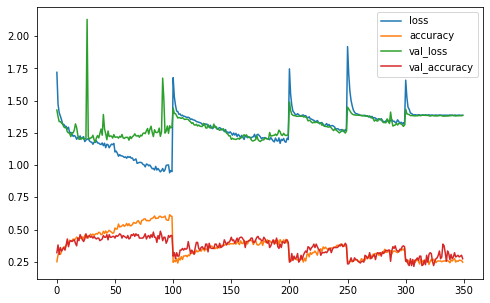

In [71]:
History_plotter(his)


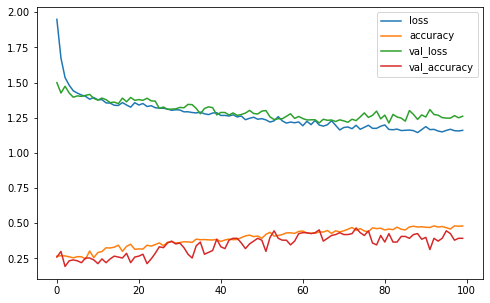

[1.1773306131362915,
 1.1978554725646973,
 1.1939903497695923,
 1.17960524559021,
 1.1781431436538696,
 1.1840314865112305,
 1.1703736782073975,
 1.1898702383041382,
 1.1748608350753784,
 1.1919866800308228]

In [35]:
np.shape(History)

(4, 10)

#DATA

## Lower fluctuation in validation loss function

In [0]:
model = keras.models.Sequential()

active = 'selu'

model.add(keras.layers.AvgPool1D(1, input_shape=(int(7200/under_sample),63) ))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Conv1D(filters=30, kernel_size=4, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Conv1D(filters=35, kernel_size=2, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.AvgPool1D(pool_size=3))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=25, kernel_size=5, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=10, kernel_size=3, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.MaxPool1D(pool_size=2))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=7, kernel_size=3, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=3, kernel_size=3, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.MaxPool1D(pool_size=2))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.MaxPooling1D(pool_size=4))
model.add(keras.layers.Flatten())

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(50, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation = active, kernel_initializer="he_normal"))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(4, activation='softmax', kernel_initializer="he_normal"))

#Lower Fluctiotion in val_loss


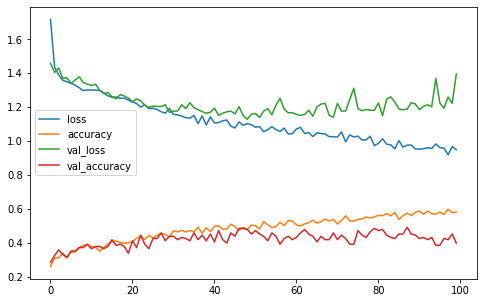

In [53]:
DataFrame(his.history).plot(figsize=(8, 5))


## All kernel sizes small

In [0]:
model = keras.models.Sequential()

active = 'selu'

model.add(keras.layers.MaxPool1D(1, input_shape=(int(7200/under_sample),63) ))
model.add(keras.layers.Conv1D(filters=60, kernel_size=4, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Conv1D(filters=40, kernel_size=2, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.MaxPool1D(pool_size=2))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=30, kernel_size=2, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=20, kernel_size=2, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.MaxPool1D(pool_size=2))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=10, kernel_size=2, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=5, kernel_size=3, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.MaxPool1D(pool_size=2))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling1D(pool_size=4))
model.add(keras.layers.Flatten())

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(50, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(10, activation = active, kernel_initializer="he_normal"))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(4, activation='softmax', kernel_initializer="he_normal"))




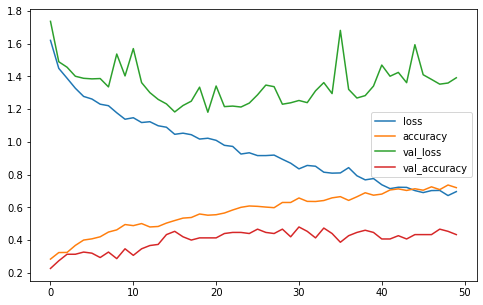

In [106]:
DataFrame(his.history).plot(figsize=(8, 5))


## All Kernel sizes are Large

In [0]:
model = keras.models.Sequential()

active = 'selu'

model.add(keras.layers.MaxPool1D(1, input_shape=(int(7200/under_sample),63) ))
model.add(keras.layers.Conv1D(filters=60, kernel_size=5, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Conv1D(filters=40, kernel_size=5, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.MaxPool1D(pool_size=2))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=30, kernel_size=5, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=20, kernel_size=5, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.MaxPool1D(pool_size=2))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=10, kernel_size=5, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=5, kernel_size=3, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.MaxPool1D(pool_size=2))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling1D(pool_size=4))
model.add(keras.layers.Flatten())

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(50, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(10, activation = active, kernel_initializer="he_normal"))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(4, activation='softmax', kernel_initializer="he_normal"))




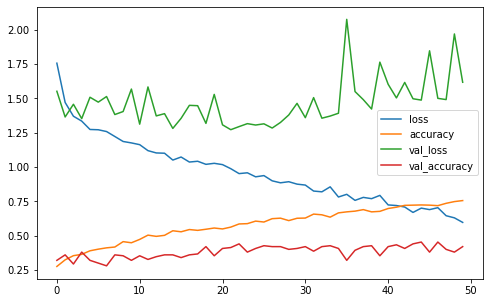

In [111]:
DataFrame(his.history).plot(figsize=(8, 5))


## Avg Pooling for all pooling layers

In [0]:
model = keras.models.Sequential()

active = 'selu'

model.add(keras.layers.AvgPool1D(1, input_shape=(int(7200/under_sample),63) ))
model.add(keras.layers.Conv1D(filters=60, kernel_size=5, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Conv1D(filters=40, kernel_size=3, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.AvgPool1D(pool_size=2))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=30, kernel_size=2, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=20, kernel_size=2, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.AvgPool1D(pool_size=2))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=10, kernel_size=2, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=5, kernel_size=2, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.AvgPool1D(pool_size=2))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling1D(pool_size=4))
model.add(keras.layers.Flatten())

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(50, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(10, activation = active, kernel_initializer="he_normal"))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(4, activation='softmax', kernel_initializer="he_normal"))


DataFrame(his.history).plot(figsize=(8, 5))


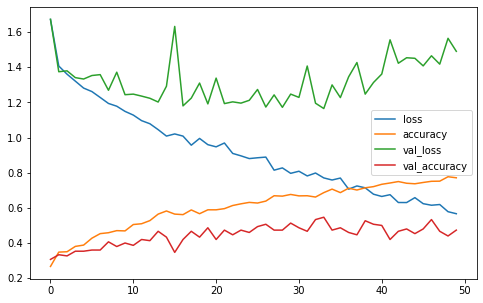

In [117]:
DataFrame(his.history).plot(figsize=(8, 5))


## Very Good Trace of losses

In [0]:
# The input signal is not under_sampled

model = keras.models.Sequential()

active = 'relu'

model.add(keras.layers.AvgPool1D(4, input_shape=(int(7200/under_sample),63) ))
model.add(keras.layers.Conv1D(filters=30, kernel_size=4, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Conv1D(filters=30, kernel_size=4, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.AvgPool1D(pool_size=2))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=20, kernel_size=3, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=10, kernel_size=3, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.MaxPool1D(pool_size=2))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=7, kernel_size=2, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=3, kernel_size=2, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.MaxPool1D(pool_size=2))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.MaxPooling1D(pool_size=4))
model.add(keras.layers.Flatten())

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(30, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation = active, kernel_initializer="he_normal"))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(4, activation='softmax', kernel_initializer="he_normal"))

#Lower Fluctiotion in val_loss


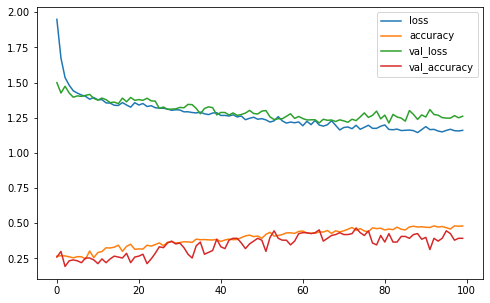

In [16]:
DataFrame(his.history).plot(figsize=(8, 5))


## One of the Best Models Ever!

On average it got 45

In [0]:
model = keras.models.Sequential()

active = 'relu'

model.add(keras.layers.AvgPool1D(4, input_shape=(int(7200/under_sample),63) ))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv1D(filters=30, kernel_size=4, activation=active, kernel_initializer="he_normal"))
#model.add(keras.layers.Dropout(0.3))
#model.add(keras.layers.Conv1D(filters=30, kernel_size=4, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.AvgPool1D(pool_size=3))

#model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=20, kernel_size=3, activation=active, kernel_initializer="he_normal"))
#model.add(keras.layers.Dropout(0.3))
#model.add(keras.layers.BatchNormalization())
#model.add(keras.layers.Conv1D(filters=10, kernel_size=3, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.AvgPool1D(pool_size=3))

#model.add(keras.layers.BatchNormalization())
#model.add(keras.layers.Conv1D(filters=7, kernel_size=2, activation=active, kernel_initializer="he_normal"))
#model.add(keras.layers.Dropout(0.3))
#model.add(keras.layers.BatchNormalization())
#model.add(keras.layers.Conv1D(filters=3, kernel_size=2, activation=active, kernel_initializer="he_normal"))
#model.add(keras.layers.MaxPool1D(pool_size=2))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.MaxPooling1D(pool_size=4))
model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(100, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Dense(50, activation = active, kernel_initializer="he_normal"))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(4, activation='softmax', kernel_initializer="he_normal"))

#Lower Fluctiotion in val_loss


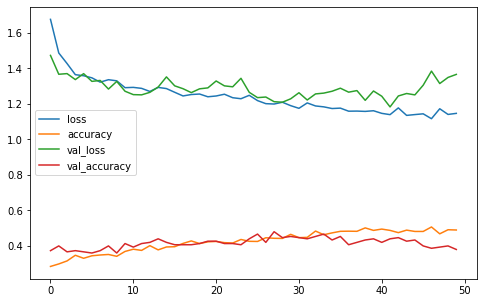

In [31]:
DataFrame(his.history).plot(figsize=(8, 5))


## Very Good Loss function for val

In [0]:
model = keras.models.Sequential()

active = 'relu'

model.add(keras.layers.AvgPool1D(4, input_shape=(int(7200/under_sample),63) ))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv1D(filters=30, kernel_size=4, activation=active, kernel_initializer="he_normal"))
#model.add(keras.layers.Dropout(0.3))
#model.add(keras.layers.Conv1D(filters=30, kernel_size=4, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.AvgPool1D(pool_size=3))

#model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=20, kernel_size=3, activation=active, kernel_initializer="he_normal"))
#model.add(keras.layers.Dropout(0.3))
#model.add(keras.layers.BatchNormalization())
#model.add(keras.layers.Conv1D(filters=10, kernel_size=3, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.AvgPool1D(pool_size=3))

#model.add(keras.layers.BatchNormalization())
#model.add(keras.layers.Conv1D(filters=7, kernel_size=2, activation=active, kernel_initializer="he_normal"))
#model.add(keras.layers.Dropout(0.3))
#model.add(keras.layers.BatchNormalization())
#model.add(keras.layers.Conv1D(filters=3, kernel_size=2, activation=active, kernel_initializer="he_normal"))
#model.add(keras.layers.MaxPool1D(pool_size=2))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.MaxPooling1D(pool_size=4))
model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(100, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(50, activation = active, kernel_initializer="he_normal"))
model.add(keras.layers.Dense(20, activation=active,  kernel_initializer="he_normal" ))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(4, activation='softmax', kernel_initializer="he_normal"))

#Lower Fluctiotion in val_loss


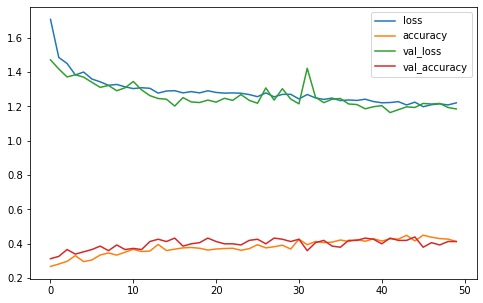

In [37]:
DataFrame(his.history).plot(figsize=(8, 5))


## A

## A

## A

## A